<h3>Header</h3>

<h5>External Modules</h5>

In [1]:
# Utils
import matplotlib.pyplot as plt
#import pandas as pd
import random
import os
from PIL import Image, ImageOps
import numpy as np

# PyTorch
import torch
import torch.nn as nn
#from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#from torchvision.io import read_image
import torchvision.transforms as transforms

<h5>Internal Modules</h5>

In [2]:
from dataset import pikfix_dataset, plot_data
from utils.degrade_image import degrade_image

<h5>Data path</h5>

In [3]:
# Define dataset root directory and it's csv file
data_dir = './data/'
csv_file = 'dataset.csv'

<h3>Main</h3>

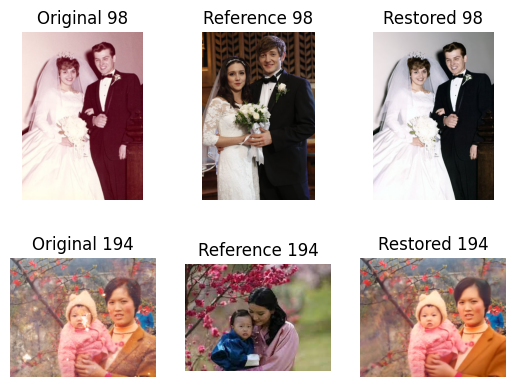

In [4]:
# Define the transformation to be applied on the images in the dataset
transform = transforms.Compose([transforms.ToTensor()])

# Build dataset
dataset = pikfix_dataset.PikFixData(data_dir + csv_file, data_dir, transform)

# Plot some random samples
plot_data.plot_random_samples(2, dataset)

Image degradation

In [ ]:
# Images and textures folder
images_folder = "data/res"
textures_folder = "data/textures"

# Select a random image
random_img = os.path.join(images_folder, random.choice(os.listdir(images_folder)))

# Degrade it
ruined_version = degrade_image(img=random_img, textures_folder=textures_folder, degradation_level=4, scaling_factor=4)

# Plot the result
fig, axs = plt.subplots(1, 2, figsize=(12,12))

plt.subplot(1,2,1)
plt.imshow(Image.open(random_img), cmap='gray')

plt.title(f'Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(ruined_version, cmap='gray')
plt.title(f'Ruined')
plt.axis('off')

#plt.savefig("version1.jpeg", bboh_inches='tight')

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
train_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
it = iter(train_loader)

In [7]:
original, reference, ruined = next(it)
original = original.to(torch.float32)

In [8]:
import torch
from torch import nn


class DenseUnit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseUnit, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.relu(self.conv(x))], 1)


class RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_units):
        super(RDB, self).__init__()
        self.units = nn.Sequential(*[DenseUnit(in_channels + growth_rate * i, growth_rate) for i in range(num_units)])

        # local feature fusion
        self.lff = nn.Conv2d(in_channels + growth_rate * num_units, growth_rate, kernel_size=1)

    def forward(self, x):
        return x + self.lff(self.units(x))  # local residual learning


class RDN(nn.Module):
    def __init__(self, scale_factor, num_channels, num_features, growth_rate, num_blocks, num_units):
        super(RDN, self).__init__()
        self.G0 = num_features
        self.G = growth_rate
        self.D = num_blocks
        self.C = num_units

        # shallow feature extraction
        self.sfe1 = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=3 // 2)
        self.sfe2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=3 // 2)

        # residual dense blocks
        self.rdbs = nn.ModuleList([RDB(self.G0, self.G, self.C)])
        for _ in range(self.D - 1):
            self.rdbs.append(RDB(self.G, self.G, self.C))

        # global feature fusion
        self.gff = nn.Sequential(
            nn.Conv2d(self.G * self.D, self.G0, kernel_size=1),
            nn.Conv2d(self.G0, self.G0, kernel_size=3, padding=3 // 2)
        )

        #up-sampling
        assert 2 <= scale_factor <= 4
        if scale_factor == 2 or scale_factor == 4:
            self.upscale = []
            for _ in range(scale_factor // 2):
                self.upscale.extend([nn.Conv2d(self.G0, self.G0 * (2 ** 2), kernel_size=3, padding=3 // 2),
                                     nn.PixelShuffle(2)])
            self.upscale = nn.Sequential(*self.upscale)
        else:
            self.upscale = nn.Sequential(
                nn.Conv2d(self.G0, self.G0 * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
                nn.PixelShuffle(scale_factor)
            )

        #self.upscale = nn.Upsample(scale_factor=scale_factor, mode='bilinear')

        self.output = nn.Conv2d(self.G0, num_channels, kernel_size=3, padding=3 // 2)

    def forward(self, x):
        sfe1 = self.sfe1(x)
        sfe2 = self.sfe2(sfe1)

        x = sfe2
        local_features = []
        for i in range(self.D):
            x = self.rdbs[i](x)
            local_features.append(x)

        x = self.gff(torch.cat(local_features, 1)) + sfe1  # global residual learning
        x = self.upscale(x)
        x = self.output(x)
        return x


In [11]:
weights_file = "../     weights/rdn_x4.pth" 
image_file = "data/5.png"
scale = 4 
num_features = 64 
growth_rate = 64 
num_blocks = 16 
num_layers = 8

model = RDN(scale_factor=scale,
            num_channels=3,
            num_features=num_features,
            growth_rate=growth_rate,
            num_blocks=num_blocks,
            num_layers=num_layers)

state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

In [12]:
output = model(original)

In [13]:
output.shape

torch.Size([1, 3, 2400, 1600])

In [14]:
class RestorationSubNet(nn.Module):
    def __init__(self):
        super(RestorationSubNet, self).__init__()
        self.RDNx1 = RDN(scale_factor=4, num_channels=3, num_features=3, growth_rate=3, num_blocks=3, num_units=4)
        self.RDNx4 = RDN(scale_factor=4, num_channels=3, num_features=3, growth_rate=3, num_blocks=3, num_units=4)
        self.RDNx8 = RDN(scale_factor=4, num_channels=3, num_features=3, growth_rate=3, num_blocks=3, num_units=4)

        self.upscalex4 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.upscalex8 = nn.Upsample(scale_factor=8, mode='bilinear')


    def forward(self, x):
        
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]


        outx1 = self.RDNx1(x1)
        outx4 = self.RDNx4(x2)
        outx8 = self.RDNx8(x3)        

        outx4 = self.upscalex4(outx4)
        outx8 = self.upscalex8(outx8)

        print(outx1.shape)
        print(outx4.shape)
        print(outx8.shape)

        out = torch.cat([outx1, outx4, outx8])

        return out

In [32]:
rest = RestorationSubNet()

In [33]:
originalx4 = torch.nn.functional.interpolate(original, scale_factor=.25, mode='bilinear')
originalx8 = torch.nn.functional.interpolate(original, scale_factor=.125, mode='bilinear')

In [17]:
original.shape

torch.Size([1, 3, 600, 400])

In [18]:
originalx4.shape

torch.Size([1, 3, 150, 100])

In [19]:
originalx8.shape

torch.Size([1, 3, 75, 50])

In [20]:
out = rest([original, originalx4, originalx8])

torch.Size([1, 3, 2400, 1600])
torch.Size([1, 3, 2400, 1600])
torch.Size([1, 3, 2400, 1600])


In [34]:
out.shape

torch.Size([3, 3, 2400, 1600])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


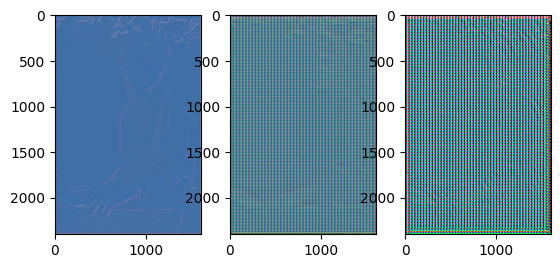

In [41]:
plt.subplots(1,3)


for i, img in enumerate(out):
    plt.subplot(1,3,i+1)
    plt.imshow(img.detach().numpy().transpose(1,2,0))
